In [3]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load metadata
file_path = "C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx"
df = pd.read_excel(file_path)

# Define image directory (same folder as the Excel sheet)
image_dir = os.path.dirname(file_path)

# Convert categorical columns to string before encoding
df = df.astype(str)

# Encode categorical variables
label_encoders = {}
categorical_cols = ['midas_gender', 'midas_fitzpatrick', 'midas_ethnicity', 'midas_race']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Convert numerical columns to float and handle errors
numerical_cols = ['midas_age', 'length_(mm)', 'width_(mm)']
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')


df_raw = df.copy()


# Normalize numerical variables
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols].fillna(0))

# Define target variable
df['target'] = df['midas_melanoma'].map({'yes': 1, 'no': 0})

# Remove rows with missing labels
df = df.dropna(subset=['target']).reset_index(drop=True)

# Debugging: Check unique label values and types
print("Unique label values:", df["target"].unique())
print("Label data type:", df["target"].dtype)

# Remove rows where the image file is missing
def file_exists(filename):
    possible_paths = [
        os.path.join(image_dir, filename),
        os.path.join(image_dir, filename.replace('.jpg', '.jpeg')),
        os.path.join(image_dir, filename.replace('.jpeg', '.jpg'))
    ]
    return any(os.path.exists(path) for path in possible_paths)

df = df[df['midas_file_name'].apply(file_exists)].reset_index(drop=True)

# Define dataset class
class MRAMIDASDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Load image with flexible file extension handling
        img_filename = row['midas_file_name']
        img_path = os.path.join(self.image_dir, img_filename)
        
        if not os.path.exists(img_path):
            # Try alternative extensions
            img_path_jpeg = img_path.replace('.jpg', '.jpeg')
            img_path_jpg = img_path.replace('.jpeg', '.jpg')
            if os.path.exists(img_path_jpeg):
                img_path = img_path_jpeg
            elif os.path.exists(img_path_jpg):
                img_path = img_path_jpg
            else:
                raise FileNotFoundError(f"Image not found: {img_filename}")
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Load metadata
        metadata_values = row[categorical_cols + numerical_cols].values.astype(float)
        metadata = torch.tensor(metadata_values, dtype=torch.float32)
        
        # Ensure label is an integer before creating tensor
        label = int(row['target'])  # Convert from potential object type
        label = torch.tensor(label, dtype=torch.int64)
        
        return image, metadata, label

# # Define image transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images
    transforms.RandomRotation(10),  # Small rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create dataset and dataloader
dataset = MRAMIDASDataset(df, image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define CNN for image processing
class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 128)
    
    def forward(self, x):
        return self.model(x)

# # Define MLP for metadata processing
# class MetadataModel(nn.Module):
#     def __init__(self, input_size):
#         super(MetadataModel, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_size, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU()
#         )
    
#     def forward(self, x):
#         return self.fc(x)

class MetadataModel(nn.Module):
    def __init__(self, input_size):
        super(MetadataModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32)
        )
    
    def forward(self, x):
        return self.fc(x)


# Define Multimodal Model
class MultimodalModel(nn.Module):
    def __init__(self, image_model, metadata_model):
        super(MultimodalModel, self).__init__()
        self.image_model = image_model
        self.metadata_model = metadata_model
        self.classifier = nn.Linear(128 + 32, 2)
    
    def forward(self, image, metadata):
        img_features = self.image_model(image)
        meta_features = self.metadata_model(metadata)
        combined = torch.cat((img_features, meta_features), dim=1)
        return self.classifier(combined)

# Move model to GPU
image_model = ImageModel().to(device)
metadata_model = MetadataModel(input_size=len(categorical_cols) + len(numerical_cols)).to(device)
model = MultimodalModel(image_model, metadata_model).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.5)

print(f"Using device: {device}")

num_epochs = 10
# for epoch in range(num_epochs):
#     start_time = time.time()  # Start timer
#     total_loss = 0
#     correct, total = 0, 0
#     print(f"Started epoch - {epoch+1}")

#     for images, metadata, labels in dataloader:
#         images, metadata, labels = images.to(device), metadata.to(device), labels.to(torch.int64).to(device)
#         model = model.to(device)  # Ensure model is on the correct device
#         optimizer.zero_grad()
#         outputs = model(images, metadata)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)
    
#     accuracy = correct / total
#     epoch_time = time.time() - start_time  # End timer

#     scheduler.step()
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f} seconds")



Unique label values: [0. 1.]
Label data type: float64
Using device: cpu


c:\Users\91935\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\91935\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
import numpy as np

print(f"Class distribution:\n{df['target'].value_counts(normalize=True)}")

Class distribution:
target
0.0    0.802584
1.0    0.197416
Name: proportion, dtype: float64


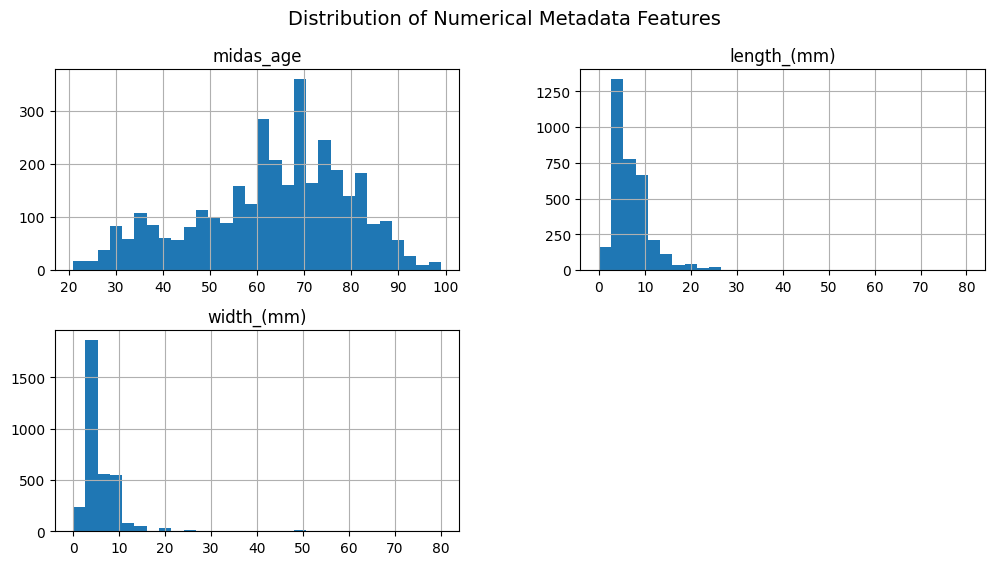

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Plot histograms for numerical columns
numerical_cols = ['midas_age', 'length_(mm)', 'width_(mm)']

df_raw[numerical_cols].hist(figsize=(12, 6), bins=30)
plt.suptitle("Distribution of Numerical Metadata Features", fontsize=14)
plt.show()

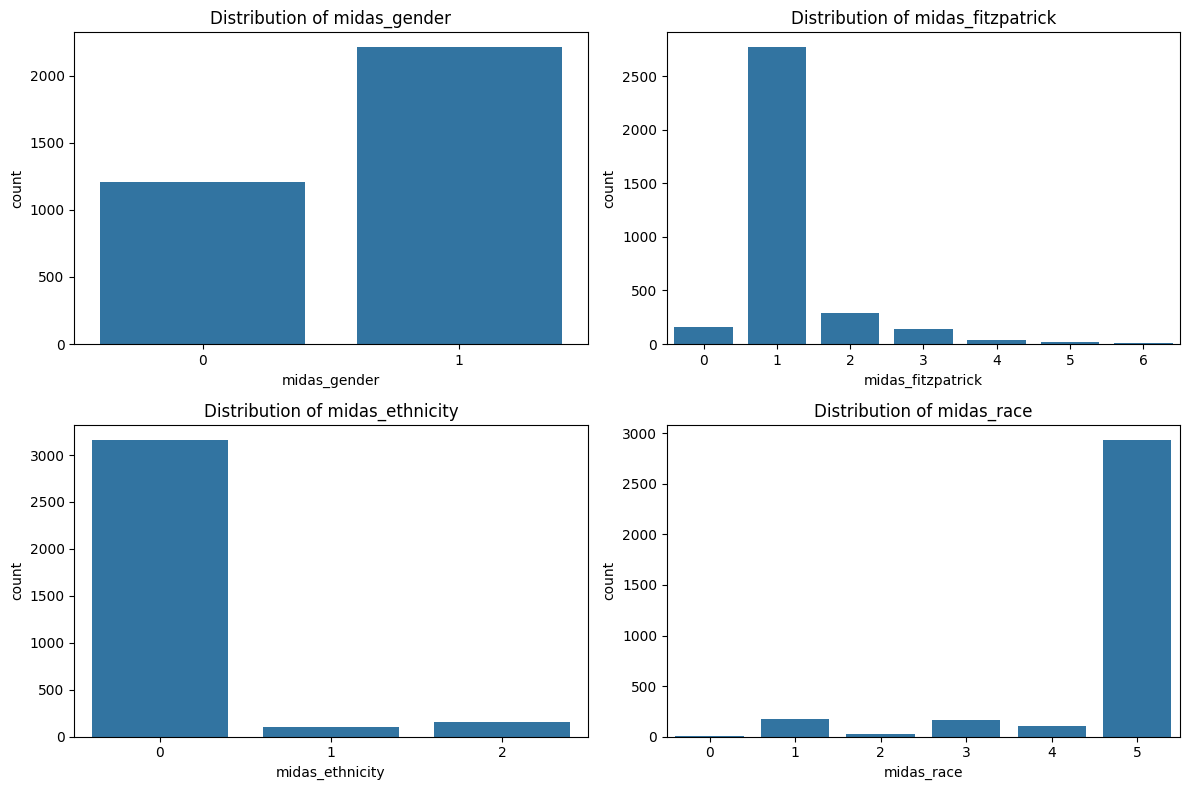

In [5]:
categorical_cols = ['midas_gender', 'midas_fitzpatrick', 'midas_ethnicity', 'midas_race']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=df_raw[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


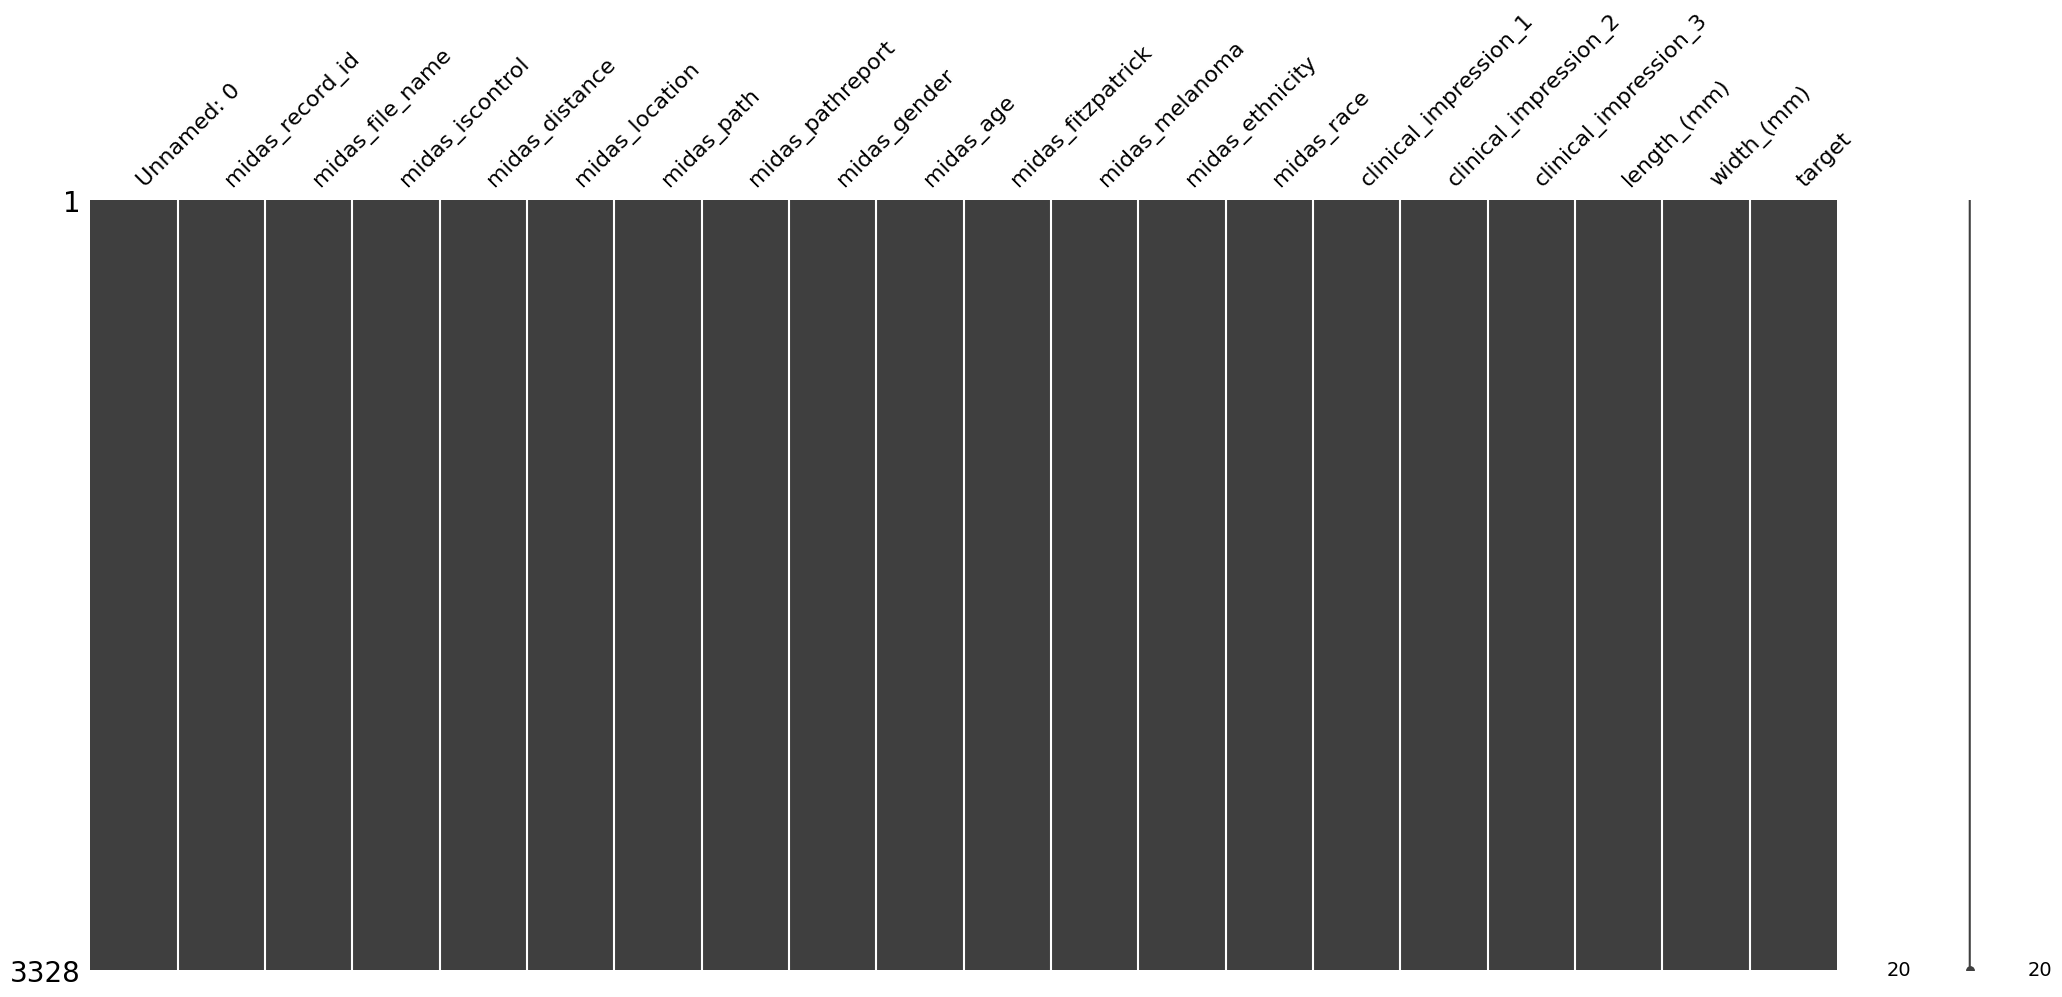

In [4]:
msno.matrix(df)
plt.show()

In [12]:
print("Checking image file paths in dataset...")
for idx in range(10):  # Check first 10 images
    img_filename = df.loc[idx, 'midas_file_name']
    img_path = os.path.join(image_dir, img_filename)
    print(f"Image {idx}: {img_path}, Exists: {os.path.exists(img_path)}")

Checking image file paths in dataset...
Image 0: C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer\s-prd-398966407.jpg, Exists: True
Image 1: C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer\s-prd-398966642.jpg, Exists: True
Image 2: C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer\s-prd-398966845.jpg, Exists: True
Image 3: C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer\s-prd-398967381.jpg, Exists: True
Image 4: C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer\s-prd-398967587.jpg, Exists: True
Image 5: C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer\s-prd-398968016.jpg, Exists: True
Image 6: C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer\s-prd-398968141.jpg, Exists: True
Image 7: C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer\s-prd-399002046.jpg, Exists: True
Image 8: C:/Data/DJ/azcopydata/midasmultimodalimagedatas

In [13]:
from PIL import Image

# Try loading one image
sample_image_path = os.path.join(image_dir, df.loc[0, 'midas_file_name'])
print(f"Trying to load: {sample_image_path}")

if os.path.exists(sample_image_path):
    img = Image.open(sample_image_path)
    img.show()  # Opens image in default viewer
else:
    print("Image file not found!")

Trying to load: C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer\s-prd-398966407.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


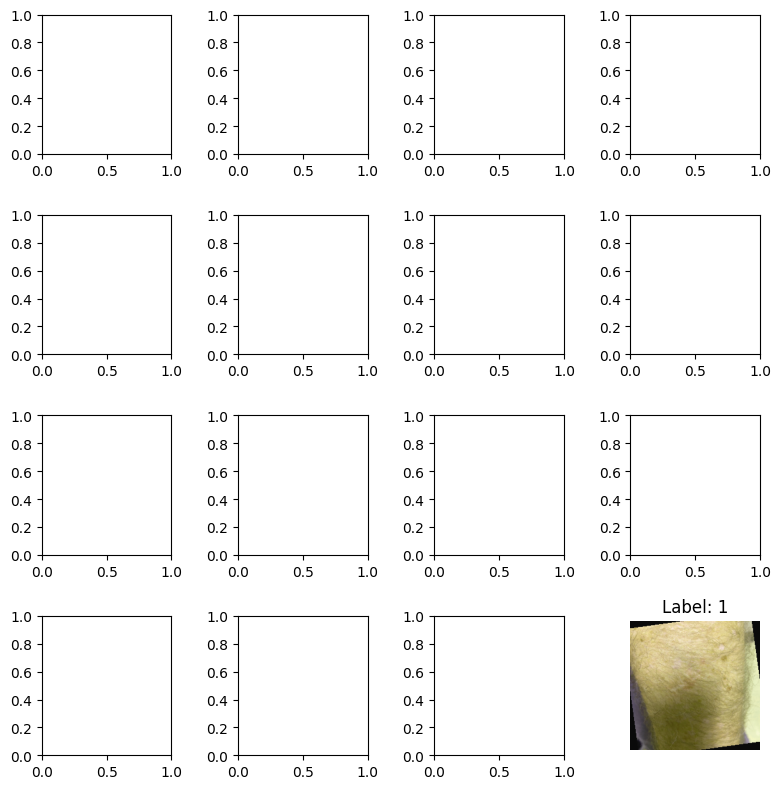

In [5]:
import torchvision.utils as vutils

# Get a batch of images
data_iter = iter(dataloader)
images, metadata, labels = next(data_iter)

# Convert images to numpy for visualization
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean  # Unnormalize
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Display images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

for i in range(16):
    imshow(images[i], title=f"Label: {labels[i].item()}")

plt.tight_layout()
plt.show()

In [6]:
loss_history = []
accuracy_history = []

# Inside training loop:
loss_history.append(total_loss)
accuracy_history.append(accuracy)

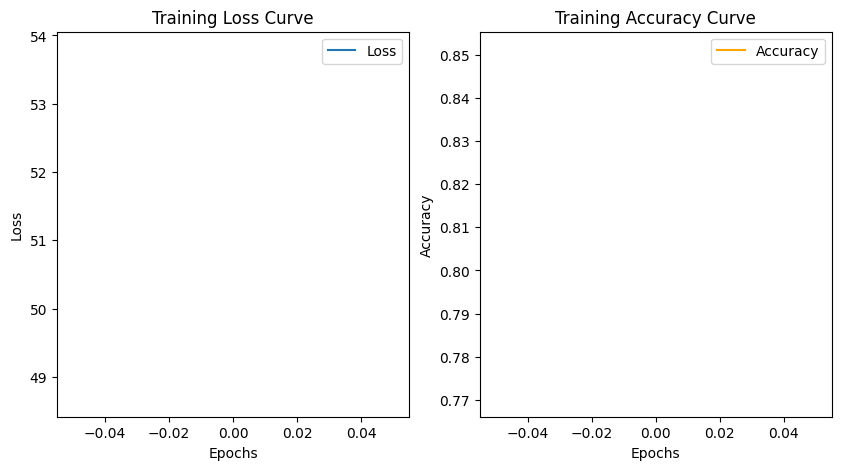

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label="Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()

plt.show()

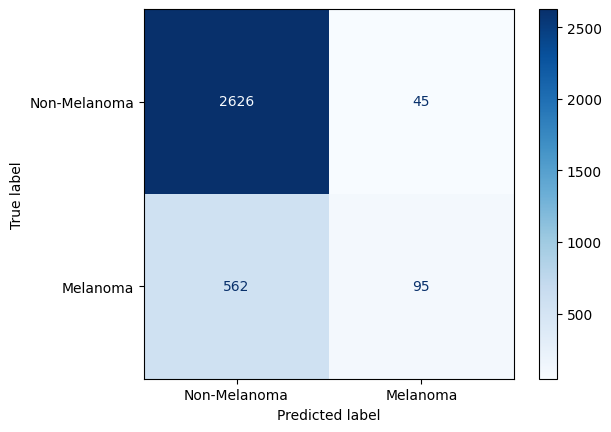

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

# Get predictions on validation/test set
with torch.no_grad():
    for images, metadata, labels in dataloader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        outputs = model(images, metadata)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Melanoma", "Melanoma"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [1]:
accuracy = cm.trace() / cm.sum()
print(f'Accuracy: {accuracy:.4f}')

NameError: name 'cm' is not defined

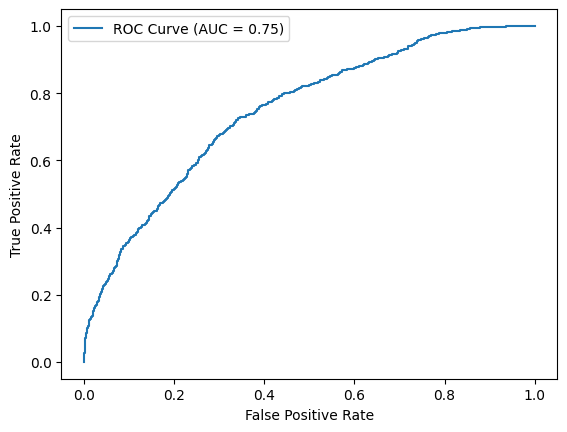

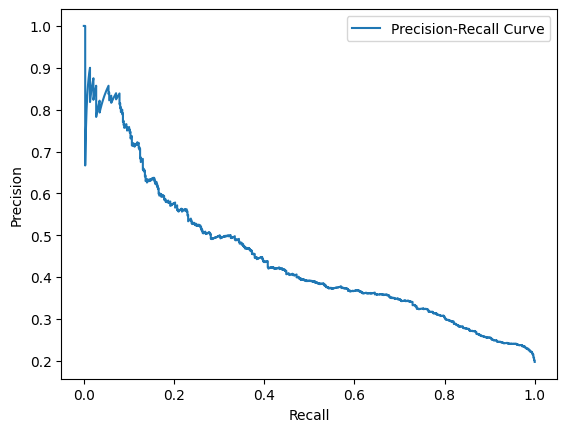

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
all_logits = []
all_labels = []

# Get model outputs (logits) for validation/test set
with torch.no_grad():
    for images, metadata, labels in dataloader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        outputs = model(images, metadata)  # Raw logits (before softmax)
        
        all_logits.extend(outputs.cpu().numpy())  # Store logits
        all_labels.extend(labels.cpu().numpy())   # Store true labels

# Convert logits to numpy
all_logits = np.array(all_logits)
all_labels = np.array(all_labels)

# Apply softmax to get probabilities
probs = torch.softmax(torch.tensor(all_logits), dim=1)[:, 1].numpy()  # Get probability of class 1

# probs = torch.softmax(torch.tensor(all_preds), dim=1)[:, 1].numpy()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, probs)

plt.figure()
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

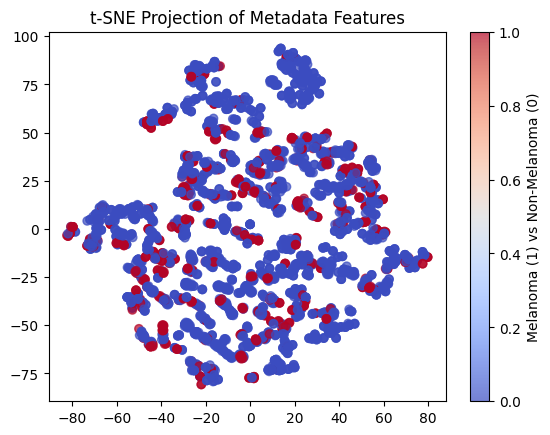

In [15]:
from sklearn.manifold import TSNE

metadata_embeddings = df[categorical_cols + numerical_cols].values
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(metadata_embeddings)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df['target'].values, cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Melanoma (1) vs Non-Melanoma (0)")
plt.title("t-SNE Projection of Metadata Features")
plt.show()

In [23]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(model, image):
    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    gradients = []  # Store gradients

    # Function to save gradients during backward pass
    def save_gradient(grad):
        gradients.append(grad)

    # Get last convolutional layer of ResNet18 inside the last `BasicBlock`
    target_layer = model.image_model.model.layer4[-1].conv2  # Access conv2 inside last BasicBlock

    # Register backward hook to save gradients
    handle = target_layer.register_backward_hook(lambda module, grad_in, grad_out: save_gradient(grad_out[0]))

    # Forward pass through the model
    metadata_dummy = torch.zeros(1, len(categorical_cols) + len(numerical_cols)).to(device)
    output = model(image, metadata_dummy)  # Forward with dummy metadata
    class_idx = output.argmax(dim=1).item()  # Get predicted class index

    # Backward pass to get gradients
    model.zero_grad()
    output[:, class_idx].backward()

    # Extract the gradients from the hook
    gradients = gradients[0]  # Extract the saved gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])  # Global average pooling

    # Get feature maps from the last convolutional layer
    with torch.no_grad():
        activations = target_layer.weight.data  # Extract feature maps

    # Apply Grad-CAM weighting
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    # Generate Grad-CAM heatmap
    heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU activation
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1

    # Remove the hook to prevent memory leaks
    handle.remove()

    return heatmap

# **Visualize Grad-CAM on a sample image**
image = images[0]  # Take first image in batch

# Compute Grad-CAM heatmap
heatmap = grad_cam(model, image)

# Convert image tensor to NumPy for visualization
image_np = image.cpu().numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])  # Normalization mean
std = np.array([0.229, 0.224, 0.225])  # Normalization std
image_np = image_np * std + mean  # Unnormalize
image_np = np.clip(image_np, 0, 1)  # Ensure valid pixel range

# Resize heatmap to match image size
heatmap_resized = cv2.resize(heatmap, (224, 224))

# Overlay Grad-CAM heatmap on the original image
plt.imshow(image_np)
plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)
plt.title("Grad-CAM Activation Map")
plt.axis("off")
plt.show()


AttributeError: 'RemovableHandle' object has no attribute 'size'

In [ ]:
from torchsummary import summary
summary(model, [(3, 224, 224), (len(categorical_cols) + len(numerical_cols),)])

# Visualize as a computational graph
from torchviz import make_dot
x_image = torch.randn(1, 3, 224, 224).to(device)
x_metadata = torch.randn(1, len(categorical_cols) + len(numerical_cols)).to(device)

dot = make_dot(model(x_image, x_metadata), params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")


AttributeError: 'RemovableHandle' object has no attribute 'size'